# IMPORT

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit, prange
from os import listdir
from os.path import isfile, join

plt.style.use(['science'])

## Ground Truth

In [2]:
# Training Data
for i in range(0,24):
    if i < 12:
        df = pd.read_csv('../data/training_data/' + str(i) + '.csv')
    else:
        df = pd.read_csv('../data/training_data/s' + str(i-12) + '.csv')
    throttle = df.throttle
    brake = df.brake
    exec("t{} = np.array(df.t).astype('float64')".format(i))
    exec("u{} = np.array([throttle, brake]).T.astype('float64')".format(i))
    exec("v{} = np.array(df.v).astype('float64')".format(i))

In [3]:
# Test Data
df = pd.read_csv('../data/test_data/test.csv')
throttle = df.throttle
brake = df.brake
tt = np.array(df.t).astype('float64')
ut = np.array([throttle, brake]).T.astype('float64')
vt = np.array(df.v).astype('float64')

df = pd.read_csv('../data/test_data/test_pid.csv')
throttle = df.throttle
brake = df.brake
ttp = np.array(df.t).astype('float64')
utp = np.array([throttle, brake]).T.astype('float64')
vtp = np.array(df.v).astype('float64')

## Simulation Results

In [4]:
dir_names =  ['pso', 'apso', 'fpa_original', 'fpa']
param_names = ['a1', 'a2', 'a3',
               'b1', 'b2', 'b3', 'b4',
               'c1', 'c2', 'c3', 'c4',
               'td11', 'td12', 'td13',
               'td21', 'td22', 'td23']

data_loss = {}
data_loss_summary = {'name': [], 'min': [], 'max': [], 'mean': [], 'std': []}
data_best_loss_history = {}
data_best_param = {'name': []}
for param_name in param_names:
    data_best_param[param_name] = []

temp = np.Inf
    
for dir_name in dir_names:
    lh = np.load('../'+dir_name+'/result/loss_history.npy')
    ph = np.load('../'+dir_name+'/result/param_history.npy')
    lb = np.load('../'+dir_name+'/result/the_best_loss_history.npy')
    pb = np.load('../'+dir_name+'/result/the_best_param_history.npy')
    
    data_loss[dir_name] = lh
    
    data_best_loss_history[dir_name] = lb
    
    data_loss_summary['name'].append(dir_name)
    data_loss_summary['min'].append(lb[-1])
    data_loss_summary['max'].append(lh.max())
    data_loss_summary['mean'].append(np.mean(lh))
    data_loss_summary['std'].append(np.std(lh))
    
    data_best_param['name'].append(dir_name)
    for i in range(len(param_names)):
        data_best_param[param_names[i]].append(pb[-1][i])
        
    if lb[-1] < temp:
        alg_name = dir_name
        params = np.copy(pb[-1])
        temp = lb[-1]

df_loss = pd.DataFrame(data_loss)
df_loss_summary = pd.DataFrame(data_loss_summary)
df_best_param = pd.DataFrame(data_best_param)
df_best_loss_history = pd.DataFrame(data_best_loss_history)

print('The minimum loss algorithm: '+ alg_name)
print(params)

The minimum loss algorithm: fpa
[-5.08357249e-02 -5.86008210e-01 -1.04600077e-15  3.38646851e-12
  2.80687486e+00  3.45156593e-02  9.39948578e-01 -5.38889767e+00
 -4.41408269e+01 -6.29121395e-02 -5.26197990e+00  4.79541959e-01
  1.56515254e+01  3.83167132e+00  2.34447720e+01  1.44621838e+00
  9.20271967e-01]


In [5]:
df_loss_summary

,name,min,max,mean,std
0,pso,0.216182,39.852123,5.812556,9.931882
1,apso,0.576478,31.471869,5.436518,8.099628
2,fpa_original,0.087230,0.855119,0.233786,0.165868
3,fpa,0.065628,0.120114,0.070048,0.011944


# Analysis

## Model

In [6]:
ndim = 17

@njit
def delayed_control_signal(i, u, u_list, td):
    if i < td:
        ut = 0.0
    else:
        if td == 0:
            ut = u
        else:
            ut = u_list[i-td]
    return ut
_ = delayed_control_signal(1, 0.1, np.array([0.1, 0.2]), 0)

@njit
def forward_propagation(t, u, param):
    a1, a2, a3, b1, b2, b3, b4, c1, c2, c3, c4, td11, td12, td13, td21, td22, td23 = param
    td11 = int(np.around(td11))
    td12 = int(np.around(td12))
    td13 = int(np.around(td13))
    td21 = int(np.around(td21))
    td22 = int(np.around(td22))
    td23 = int(np.around(td23))

    u1_list = np.empty(t.shape)
    u2_list = np.empty(t.shape)
    out = np.empty(t.shape)
    y = 0.0
    for i in range(t.shape[0]):
        if i == 0:
            dt = t[1] - t[0]
        else:
            dt = t[i] - t[i-1]
            
        u1, u2 = u[i]        
        u11t = delayed_control_signal(i, u1, u1_list, td11)
        u12t = delayed_control_signal(i, u1, u1_list, td12)
        u13t = delayed_control_signal(i, u1, u1_list, td13)
        u21t = delayed_control_signal(i, u2, u2_list, td21)
        u22t = delayed_control_signal(i, u2, u2_list, td22)
        u23t = delayed_control_signal(i, u2, u2_list, td23)
        
        temp = 0.
        if y != 0.:
            temp = a1
                    
        y_dot = temp + a2 * y + a3 * y**2 \
                + b1 * u11t + b2 * np.exp(b3 * y + b4 * u12t) * u13t \
                + c1 * u21t + c2 * np.exp(c3 * y + c4 * u22t) * u23t
        
        y += y_dot * dt
        if y < 0.0:
            y = 0.0

        u1_list[i] = u1
        u2_list[i] = u2
        out[i] = y

    return out
_ = forward_propagation(np.arange(10, dtype=float), np.random.randn(10,2), np.ones(ndim))

## Cost and Metric

In [7]:
@njit
def mean_squared_error(t, u, v, param):
    error = v - forward_propagation(t, u, param)
    out = np.mean(error**2)
    return out
_ = mean_squared_error(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(ndim))

@njit
def maximum_absolute_error(t, u, v, param):
    error = v - forward_propagation(t, u, param)
    out = np.max(np.abs(error))
    return out
_ = maximum_absolute_error(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(ndim))

@njit
def accuracy(t, u, v, param):
    error = v - forward_propagation(t, u, param)
    numerator = np.linalg.norm(error)
    denumerator = np.linalg.norm(v - np.mean(v))
    acc = 1.0 - numerator / denumerator
    return acc
_ = accuracy(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(ndim))

## Result

### Training Data

In [8]:
num = 0
for i in range(24):
    exec("num += t{}.shape[0]".format(i))
vv = np.empty(num)
vv_gt = np.empty(num)
nn = 0
for i in range(24):
    exec("n = t{}.shape[0]".format(i))
    exec("vv[nn: nn+n] = forward_propagation(t{}, u{}, params)".format(i, i))
    exec("vv_gt[nn: nn+n] = v{}".format(i))
    nn += n
total_accuracy = (1 - np.linalg.norm(vv_gt - vv)/np.linalg.norm(vv_gt - np.mean(vv_gt)))
print('Total Accuracy: {:.2f}%'.format(total_accuracy*100))

Total Accuracy: 96.05%


In [9]:
acc = []
mse = []
maer = [] 
for i in range(24):
    exec("acc.append(accuracy(t{}, u{}, v{}, params))".format(i, i, i))
    exec("mse.append(mean_squared_error(t{}, u{}, v{}, params))".format(i, i, i))
    exec("maer.append(maximum_absolute_error(t{}, u{}, v{}, params))".format(i, i, i))
    
df_metric = pd.DataFrame({'accuracy': acc, 'mean squared error (m/s)': mse, 'max. abs. error (m/s)': maer})

In [10]:
df_metric

,accuracy,mean squared error (m/s),max. abs. error (m/s)
0,0.904076,0.010379,0.494366
1,0.934182,0.052038,0.949150
2,0.948869,0.058255,0.692886
3,0.898399,0.034276,0.344574
4,0.878835,0.108543,0.818871
5,0.947465,0.072290,1.008719
6,0.960418,0.049099,1.038398
7,0.856090,0.082380,0.700173
8,0.774835,0.038602,0.253037
9,0.905649,0.030792,0.432466


### Test Data

In [11]:
print("Test Data 1")
print('acc: {}'.format(accuracy(tt, ut, vt, params)))
print('mse: {}'.format(mean_squared_error(tt, ut, vt, params)))
print('maer: {}'.format(maximum_absolute_error(tt, ut, vt, params)))
print('')
print("Test Data PID")
print('acc: {}'.format(accuracy(ttp, utp, vtp, params)))
print('mse: {}'.format(mean_squared_error(ttp, utp, vtp, params)))
print('maer: {}'.format(maximum_absolute_error(ttp, utp, vtp, params)))

Test Data 1
acc: 0.9390355109529067
mse: 0.031174918967830527
maer: 0.4126550510509013

Test Data PID
acc: 0.9367955545388897
mse: 0.06206736746919006
maer: 0.4706700212931958


## Visualization

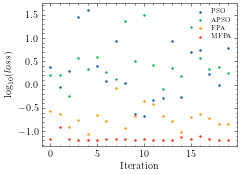

In [12]:
plt.figure()
names = ['PSO', 'APSO', 'FPA', 'MFPA']
for i in range(len(dir_names)):
    plt.scatter(df_loss.index.values, np.log10(df_loss[dir_names[i]]), s=2., label=names[i])
plt.xlabel('Iteration')
plt.ylabel('$\mathrm{log}_{10}(loss)$')
plt.legend(prop={'size': 6})
plt.savefig('img/stability_check.png', dpi=600, transparent=True)
plt.show()

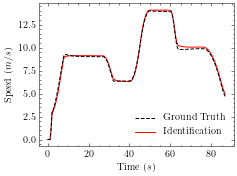

In [13]:
# Test Data 1
vvt = forward_propagation(tt, ut, params)
plt.figure()
plt.plot(tt, vt, label='Ground Truth', zorder=2, color='black', linestyle='--')
plt.plot(tt, vvt, label='Identification', zorder=1, color='red')
plt.xlabel('Time $(s)$')
plt.ylabel('Speed $(m/s)$')
plt.legend()
plt.savefig('img/performance_test_data.png', dpi=600, transparent=True)
plt.show()

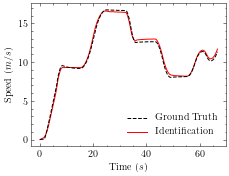

In [14]:
# Test Data PID
vvtp = forward_propagation(ttp, utp, params)
plt.figure()
plt.plot(ttp, vtp, label='Ground Truth', zorder=2, color='black', linestyle='--')
plt.plot(ttp, vvtp, label='Identification', zorder=1, color='red')
plt.xlabel('Time $(s)$')
plt.ylabel('Speed $(m/s)$')
plt.legend()
plt.savefig('img/performance_test_data_pid.png', dpi=600, transparent=True)
plt.show()